In [13]:
import numpy as np
from py21cmsense import Observatory, hera, GaussianBeam
from astropy.cosmology import Planck15
from py21cmsense.conversions import dk_du, f2z
import tqdm
import astropy.units as un
from astropy.cosmology.units import littleh
import matplotlib.pyplot as plt

In [14]:
def compare(tools_qt, tuesday_qt, qt_name="", vmin=None, vmax=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    if vmin is None:
        vmin = np.nanpercentile(tools_qt, 2.5)
    if vmax is None:
        vmax = np.nanpercentile(tools_qt, 97.5)
    axs[0].set_title(f"tuesday - {qt_name} at 150 MHz for SKA AA4")
    axs[0].imshow(np.flip(tuesday_qt.T), origin="lower", vmin = vmin, vmax = vmax)
    axs[1].set_title(f"Current tools21cm - {qt_name} at 150 MHz for SKA AA4")
    axs[1].imshow(tools_qt.T, origin="lower", vmin = vmin, vmax = vmax)
    plt.show()
    err = tools_qt.T - np.flip(tuesday_qt.T)
    vmin = np.nanpercentile(err, 2.5)
    vmax = np.nanpercentile(err, 97.5)
    fig, axs = plt.subplots(1,2, figsize=(12, 6))
    im = axs[0].imshow(err, vmin = vmin, vmax = vmax, origin="lower")
    fig.colorbar(im,  label = f"tools21cm  {qt_name} - 21cmSense {qt_name}", fraction=0.1,shrink=0.8)
    axs[1].hist(err.ravel(), bins = np.linspace(vmin,vmax,20))
    axs[1].set_xlabel(f"tools21cm {qt_name} - 21cmSense {qt_name}")
    plt.show()

In [2]:
hours_tracking = 3.*un.hour
observatory = Observatory.from_profile("SKA-LOW1-central")
freqs = [150.0 * un.MHz, 200.0 * un.MHz]

In [3]:
observatory = observatory.clone(beam=observatory.beam.clone(frequency=freqs[0]))
integration_time = 60*un.s
time_offsets = observatory.time_offsets_from_obs_int_time(integration_time, hours_tracking)

In [4]:
baseline_groups = observatory.get_redundant_baselines()
baselines = observatory.baseline_coords_from_groups(baseline_groups)
weights = observatory.baseline_weights_from_groups(baseline_groups)
bl_max = np.sqrt(np.max(np.sum(baselines**2, axis=1)))

finding redundancies: 100%|██████████| 295/295 [00:00<00:00, 989.90ants/s]


In [5]:
from tuesday.core import grid_baselines

In [ ]:
proj_bls = observatory.projected_baselines(baselines=baselines, #21cmsense caches them 
                                           time_offset = time_offsets, ) #(Nbls, N time_offsets, 3)

In [9]:
lc_shape = np.array([200,200,1945])
boxlength = 300. *un.Mpc
uv_coverage = np.zeros((len(freqs),lc_shape[0],lc_shape[0]))#Nfreqs, Nu, Nv

In [10]:
for i, freq in enumerate(freqs): #number of lc z slices / chunks (e.g. in Matteo's paper) -> big
    # uv coverage integrated over one field
    uv_coverage[i] += grid_baselines(proj_bls*freq/freqs[0],
                              freq,
                        boxlength, 
                        lc_shape,
                        weights)

In [11]:
uv_coverage.shape

(2, 200, 200)

In [12]:
freqs

[<Quantity 150. MHz>, <Quantity 200. MHz>]

In [17]:
from test_david import compute_uv_coverage, noise

In [ ]:
redshifts = [f2z(freq) for freq in freqs]
uv_tools = np.fft.fftshift(compute_uv_coverage(redshifts, 
                             ncells=lc_shape[0], 
                             boxsize=boxlength.value,
                             int_time=integration_time.value,
                             total_int_time= hours_tracking.value,))

0 Making uv map from daily observations.
Completed: 100.0 %1 Making uv map from daily observations.
Completed: 100.0 %

In [ ]:
uv_tools.shape

(200, 200, 2)

In [20]:
redshifts

[8.469371678466665, 6.10202875885]

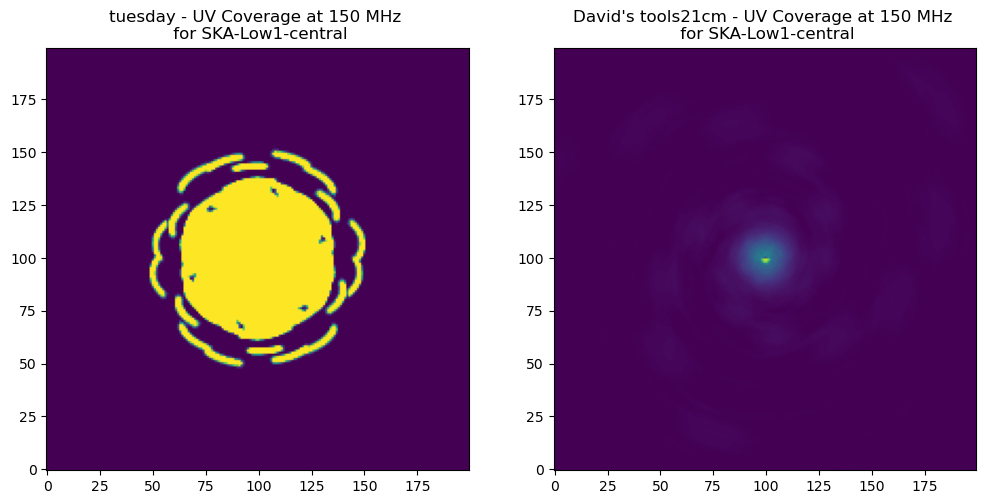

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title("tuesday - UV Coverage at 150 MHz \n for SKA-Low1-central")
axs[0].imshow(uv_coverage[0].T, origin="lower", vmin = 0, vmax = 200)
axs[1].set_title("David's tools21cm - UV Coverage at 150 MHz \n for SKA-Low1-central")
axs[1].imshow(uv_tools[...,0].T, origin="lower", vmin = 0, vmax = 200)

